# KPACUBO demo: S&P500 index study

## Introduction
_S&P500_ is a poplar US market index covering about 80% of the available market capitalization (https://www.spglobal.com/spdji/en/indices/equity/sp-500). _S&P500_ is computed as:

_S&P500 = sum(Coefficient \* SharePrice \* FloatingShareAmount)_,

where sum is taken over top 500 US companies. For each of these companies, the formula above includes three types of data: the price of a share, the total amount of shares available for public trade, and a coefficient. These three types of data are not available equally. While it's easy to obtain historical values of share prices, historical data about floating shares and _S&P500_ coefficients is significantly harder to come across. In this demo, we use share price data to get some insight into the _S&P500_ coefficients and floating share amounts.

In [17]:
import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from kpacuboLib.Persistence import CacheManager, CachesDataFrame, CachesTimeSeries
from kpacuboLib.Result import FailsWhenThrows
from kpacuboLib.LinePlot import XY

## Data management
This case study is based on the data between 01.01.2010 and 01.01.2022: 

In [18]:
(caseStart, caseEnd) = ('2010-01-01', '2022-01-01')

To minimize the amount of data to download, we employ memoization:

In [19]:
@CachesTimeSeries(CacheManager('Cache'))
@FailsWhenThrows
def Fetch(symbol, source, start, end):
    return DataReader(symbol, source, start, end).dropna()

Federal Reserve provides 10 years worth of _S&P500_ data. This is not quite sufficient for us, so we use the share price of _SPY_ ETF from Yahoo Finance instead. This is a good approximation, as the ratio of _SPY_ share price to _S&P500_ remains within 1% of 0.1.

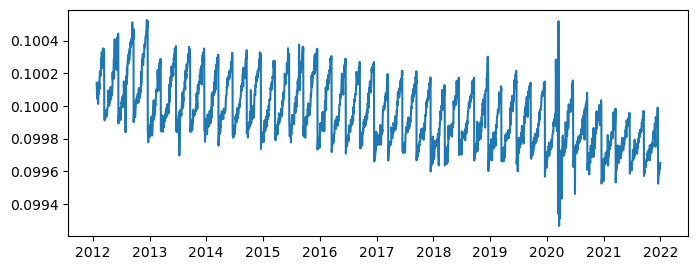

In [20]:
sp500 = Fetch('sp500', 'fred', caseStart, caseEnd).Value['sp500']
spy = Fetch('SPY', 'yahoo', caseStart, caseEnd).Value['Close']
XY().Plot(spy[spy.index>=sp500.index[0]].index, spy[spy.index>=sp500.index[0]] / sp500)

The list of companies included in _S&P500_ can be downloaded from Wikipedia:

In [21]:
@CachesDataFrame(CacheManager('Cache', prefix='sp500_constituents'))
@FailsWhenThrows
def sp500Constituents():
    return pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500Constituents().Value.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


While historical data about share prices of the companies above is freely available on Yahoo Finance:

In [22]:
sp500SharePrice = pd.DataFrame(
    {x : Fetch(x.replace('.', '-'), 'yahoo', caseStart, caseEnd).Value['Close'] 
        for x in sp500Constituents().Value['Symbol']}).fillna(0)

sp500SharePrice.head()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,WYNN,XEL,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,83.019997,7.435000,26.129908,0.0,8.74,42.070000,11.30,31.469999,37.090000,37.603161,...,70.913910,63.959999,21.080000,25.379999,0.0,25.226456,28.670000,60.020000,13.33,0.0
2010-01-05,82.500000,7.340000,25.918797,0.0,8.53,42.330002,11.32,31.639999,37.700001,37.401230,...,70.754967,67.849998,20.830000,25.059999,0.0,25.140186,28.620001,61.919998,13.80,0.0
2010-01-06,83.669998,7.343333,26.062737,0.0,8.40,42.779999,11.26,31.559999,37.619999,37.313435,...,71.894043,66.959999,20.870001,24.889999,0.0,24.960461,28.400000,61.900002,15.00,0.0
2010-01-07,83.730003,7.365000,26.278646,0.0,8.40,42.740002,10.99,31.230000,36.889999,37.295876,...,71.682121,68.389999,20.780001,24.639999,0.0,24.953272,27.690001,63.320000,16.68,0.0
2010-01-08,84.320000,7.473333,26.412991,0.0,8.23,42.570000,10.90,30.840000,36.689999,37.243195,...,71.602646,67.900002,20.790001,25.000000,0.0,24.960461,27.600000,61.990002,16.41,0.0


## Regression analysis
We argue that _S&P500_ coefficients and floating share amounts change less often compared to the share prices. Therefore, difference between daily values of _S&P500_ may be computed as,

_D S&P500 ~ sum(Coefficient \* FloatingShareAmount \* D SharePrice)_.

The approximation above allows us to use linear regression to obtain estimated values of the product _Coefficient \* FloatingShareAmount_ for each of the assets included in _S&P500_.

In [23]:
dxs = pd.DataFrame({x : sp500SharePrice[x].diff().dropna() for x in sp500SharePrice.columns})
dys = spy.diff().dropna()
model = Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LinearRegression(positive=True))]).fit(dxs,dys)

In particular, coefficients of the linear regression may sorted to obtain the list of top contributors to _S&P500_. Note that our approximation agrees well with the official info here: https://www.spglobal.com/spdji/en/indices/equity/sp-500/#data

In [24]:
coefs = pd.DataFrame({
    'Sector' : sp500Constituents().Value['GICS Sector'].values, 
    'Coef' : model[1].coef_}, index = sp500SharePrice.columns)
coefs.sort_values('Coef', ascending=False)[:10]

,Sector,Coef
AAPL,Information Technology,4.398160
MSFT,Information Technology,3.161204
AMZN,Consumer Discretionary,2.484157
FB,Communication Services,1.723435
TSLA,Consumer Discretionary,1.559840
NVDA,Information Technology,1.450405
GOOGL,Communication Services,1.230548
GOOG,Communication Services,1.165498
DIS,Communication Services,1.074128
BRK.B,Financials,0.988681


### Regression analysis by sector
Our analysis can be extended to assess the weight of different sectors in _S&P500_. Again we reproduce well the Sector Breakdown given here: https://www.spglobal.com/spdji/en/indices/equity/sp-500/#data

In [25]:
coefsBySector = coefs.groupby('Sector').sum()
(coefsBySector/coefsBySector.sum()).sort_values('Coef', ascending=False)

,Coef
Sector,
Information Technology,0.263893
Health Care,0.135923
Consumer Discretionary,0.129094
Financials,0.110522
Communication Services,0.093787
Industrials,0.082264
Consumer Staples,0.061212
Energy,0.044960
Utilities,0.028712


Finally, we can also reproduce the changes made to _S&P500_ over the last 12 years. To this end, we split our data into two intervals, use linear regression for each of the interval and compare the coefficients. Our analysis correctly indicates several trends in the _S&P500_ weighting: the growing importance of IT, and the decrease in Financials, Industrials, and Consumer Staples. 

In [26]:
def coefsByNYears(nYears):
    result = pd.DataFrame({'Sector' : sp500Constituents().Value['GICS Sector'].values}, index = sp500SharePrice.columns)
    for ((nx, gx), (_, gy)) in zip(dxs.groupby(dxs.index.year // nYears * nYears), dys.groupby(dys.index.year // nYears * nYears)):
        model = Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LinearRegression(positive=True))]).fit(gx,gy)
        result[str(nx)] = model[1].coef_
    return result

coefsByNYearsBySector = coefsByNYears(6).groupby('Sector').sum()
(coefsByNYearsBySector/coefsByNYearsBySector.sum()).sort_values('2016', ascending=False)

,2010,2016
Sector,,
Information Technology,0.222144,0.257976
Health Care,0.143931,0.137978
Consumer Discretionary,0.092151,0.131467
Financials,0.121355,0.111781
Communication Services,0.086615,0.092744
Industrials,0.098016,0.086554
Consumer Staples,0.071779,0.059437
Energy,0.080556,0.042666
Real Estate,0.018669,0.029609
